## Time Series Comparisons: Fluxes versus Forcing Functions

In [4]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

%matplotlib inline

In [5]:
plt.rcParams['font.size'] = 16

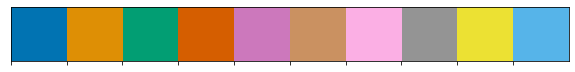

In [6]:
sns.set_palette(sns.color_palette("colorblind"))
myp = sns.color_palette('colorblind')
sns.palplot(myp)

In [7]:
def scaled_correlation(a, b, scale):
    sum_correlations = 0
    count = 0
    for i in range(len(a)//scale):
        r, _ = stats.pearsonr(
            a[i * scale: (i + 1) * scale],
            b[i * scale: (i + 1) * scale]
        )
        sum_correlations += r
        count += 1
    return sum_correlations/count

In [8]:
# Fluxes
shallow_flux = pd.read_csv('shallowflux.csv', parse_dates=[0], index_col=0)
deep_flux = pd.read_csv('deepflux.csv', parse_dates=[0], index_col=0)
baroclinic = shallow_flux + deep_flux
barotropic = shallow_flux - deep_flux

In [9]:
# Rivers
r2015 = pd.read_csv('SoG_runoff_2015.csv', parse_dates=True, index_col=0)
r2016 = pd.read_csv('SoG_runoff_2016.csv', index_col=0, parse_dates=True)
r2017 = pd.read_csv('SoG_runoff_2017.csv', index_col=0, parse_dates=True)
r2018 = pd.read_csv('SoG_runoff_2018.csv', index_col=0, parse_dates=True)
SoGrunoff = pd.concat([r2015, r2016, r2017, r2018])

In [10]:
# Wind
wind = pd.read_csv('day_avg_wind.csv', index_col=0)
wind.index = pd.to_datetime(wind.index, format="%Y-%m-%d")
low_pass_wind = wind.rolling(window=4, center=True).mean()

In [11]:
# SSH
ssh = pd.read_csv('low_pass_ssh.csv')
base = datetime.datetime(2015, 1, 1, tzinfo=datetime.timezone.utc)
date_list = [base + datetime.timedelta(days=x) for x in range(1461)]
ssh['time'] = date_list
ssh.set_index('time', inplace=True)

In [12]:
# Tides
low_pass_tide = pd.read_csv('low_pass_tide.csv', index_col=0)
low_pass_tide.index = pd.to_datetime(low_pass_tide.index, format="%Y-%m-%d")

In [13]:
# Density Forcing
sigma = pd.read_csv('sigma_2015_201806.csv', index_col=0)
m2015 = sigma.south - sigma.north
m2015.index = pd.to_datetime(m2015.index, format="%Y-%m-%d")
sigma = pd.read_csv('sigma_2016_201806.csv', index_col=0)
m2016 = sigma.south - sigma.north
m2016.index = pd.to_datetime(m2016.index, format="%Y-%m-%d")
sigma = pd.read_csv('sigma_2017_201806.csv', index_col=0)
m2017 = sigma.south - sigma.north
m2017.index = pd.to_datetime(m2017.index, format="%Y-%m-%d")
sigma = pd.read_csv('sigma_2018_201806.csv', index_col=0)
m2018 = sigma.south - sigma.north
m2018.index = pd.to_datetime(m2018.index, format="%Y-%m-%d")
goverrho=9.81/1000.
depthwidth = 50*10e3
densitydiff = pd.concat([m2015, m2016, m2017, m2018])
densityforcing = np.sqrt(goverrho*densitydiff[:])

In [14]:
densitydiff

2015-01-01 00:00:00+00:00    188.117726
2015-01-02 00:00:00+00:00    195.545107
2015-01-03 00:00:00+00:00    196.789936
2015-01-04 00:00:00+00:00    189.535515
2015-01-05 00:00:00+00:00    178.682278
                                ...    
2018-12-27 00:00:00+00:00    145.119867
2018-12-28 00:00:00+00:00    151.433523
2018-12-29 00:00:00+00:00    152.565994
2018-12-30 00:00:00+00:00    175.501618
2018-12-31 00:00:00+00:00    192.270882
Length: 1461, dtype: float64

In [15]:
x = densitydiff[:]
y = baroclinic.transport
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[1.         0.81211531]
 [0.81211531 1.        ]]


3 0.8481520997403567


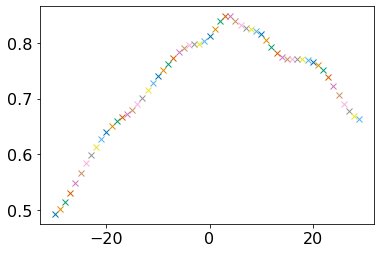

In [16]:
max = 0
for lag in range(-30, 30):
    value = baroclinic.transport.corr(densitydiff.shift(lag))
    if value > max:
        max = value
        mlag = lag
    plt.plot(lag, value, 'x')
print (mlag, max)

In [17]:
x = densityforcing[:]
y = baroclinic.transport
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[1.        0.8073329]
 [0.8073329 1.       ]]


In [18]:
x = low_pass_tide.vozocrtx.values
y = baroclinic.transport.values
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[ 1.         -0.29698463]
 [-0.29698463  1.        ]]


In [26]:
xmin = 0
sum = 0
icount = 0
for scale in range(7, 30):
    for shift in range(scale):
        correl = scaled_correlation(x[~nansInArray][shift:], y[~nansInArray][shift:], scale)
        if correl < xmin:
            print(scale, shift, correl)
            xmin = correl
        if scale == 20:
#            print (shift, correl)
            sum = sum + correl
            icount = icount + 1
print (sum/icount)

7 0 -0.5183314140976558
8 4 -0.5186335080227122
8 5 -0.5346159072380634
8 6 -0.5375378857498109
9 0 -0.5590004743163116
10 3 -0.5755258249468537
11 7 -0.5853702512774374
12 4 -0.5969262677860706
12 5 -0.6058928340650297
16 5 -0.6071867464900502
16 6 -0.6191511355224563
16 7 -0.6231722340980251
20 0 -0.6276783535421163
20 16 -0.632815023096598
20 17 -0.6384214658739567
-0.5995265343015981


-1 -0.30143435753216796


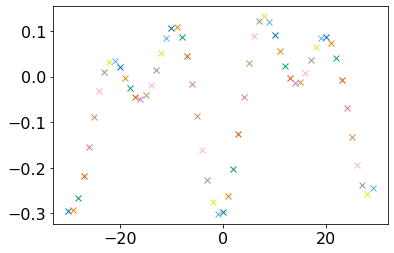

In [37]:
min = 0
tide = low_pass_tide.tz_localize(None)
trans = baroclinic.tz_localize(None)
for lag in range(-30, 30):
    value = trans.transport.corr(tide.vozocrtx.shift(lag))
    if value < min:
        min = value
        mlag = lag
    plt.plot(lag, value, 'x')
print (mlag, min)

In [19]:
x = SoGrunoff.rorunoff
y = baroclinic.transport
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[1.         0.35128684]
 [0.35128684 1.        ]]


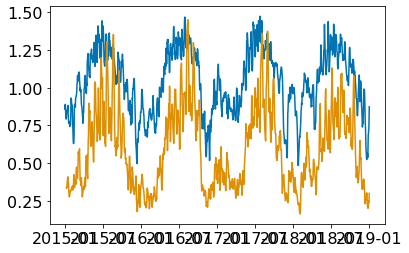

In [55]:
plt.plot(x - 0.5)
plt.plot(y/1e5)

-300 0.67016011416756


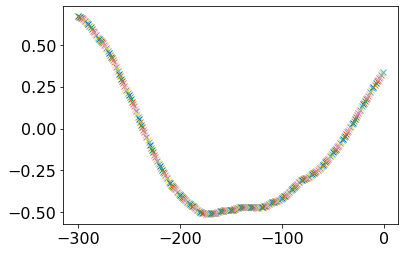

In [53]:
max = 0
for lag in range(-300, 0):
    trans = baroclinic.tz_localize(None)
    run = SoGrunoff.tz_localize(None)
    value = trans.transport.corr(run.rorunoff.shift(lag))
    if value > max:
        max = value
        mlag = lag
    plt.plot(lag, value, 'x')
print (mlag, max)

46 0.6724532507316303


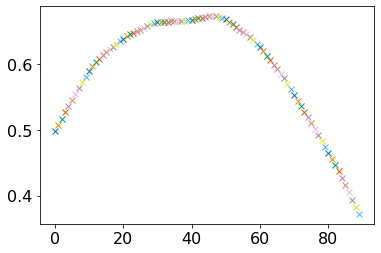

In [45]:
max = 0
for lag in range(0, 90):
    density = densitydiff.tz_localize(None)
    run = SoGrunoff.tz_localize(None)
    value = density.corr(run.rorunoff.shift(lag))
    if value > max:
        max = value
        mlag = lag
    plt.plot(lag, value, 'x')
print (mlag, max)

In [21]:
x = low_pass_wind.wind.values
y = baroclinic.transport.values
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[ 1.        -0.5397062]
 [-0.5397062  1.       ]]


In [22]:
x = low_pass_wind.wind.values
y = densitydiff[:]
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[ 1.         -0.70492634]
 [-0.70492634  1.        ]]


In [28]:
x = low_pass_wind.wind.values
y = barotropic.transport[:]
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[ 1.         -0.10037231]
 [-0.10037231  1.        ]]


In [33]:
xmin = 0
for scale in range(2, 70):
    sum = 0
    icount = 0
    for shift in range(scale):
        correl = scaled_correlation(x[~nansInArray][shift:], y[~nansInArray][shift:], scale)
        sum = sum + correl
        icount = icount + 1
    if sum/icount < xmin:
            print(scale, sum/icount)
            xmin = sum/icount

3 -0.011200018230132993
4 -0.01530209390573908
5 -0.026683606610939277
6 -0.04022024811381387
7 -0.0578778196174747
8 -0.07628291639293615
9 -0.09361381397391588
10 -0.1097476588077088
11 -0.12507890844301658
12 -0.14026034549988617
13 -0.15441651090948086
14 -0.1673362139658757
15 -0.17891324497694414
16 -0.18913053500163052
17 -0.19809858245912165
18 -0.20615872229384838
19 -0.2133109838807255
20 -0.21967100456118377
21 -0.22556717745619304
22 -0.2308115035273648
23 -0.2353183066515692
24 -0.23949863820281828
25 -0.24285832514685637
26 -0.2459802834333914
27 -0.2487052993428646
28 -0.25085063018680104
29 -0.2528195876276133
30 -0.2548367904152905
31 -0.2561883192169029
32 -0.257328821901221
33 -0.2587949694314816
34 -0.25960303471316415
35 -0.2603447725722375
36 -0.2609890329226619
37 -0.2612785709992666
38 -0.26159524882139884
39 -0.26206059965569434
40 -0.26224686478185033
41 -0.2623122942137049
42 -0.26254528705057795
43 -0.2625837371726567
44 -0.2626039389070515
45 -0.26272242165

In [24]:
x = low_pass_wind.wind.values
y = ssh.sossheig
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[1.        0.7561315]
 [0.7561315 1.       ]]


In [26]:
x = barotropic.transport
y = ssh.sossheig
nansInArray = (np.isnan(y) | np.isnan(x))
print (np.corrcoef(x[~nansInArray], y[~nansInArray]))

[[ 1.         -0.05010086]
 [-0.05010086  1.        ]]


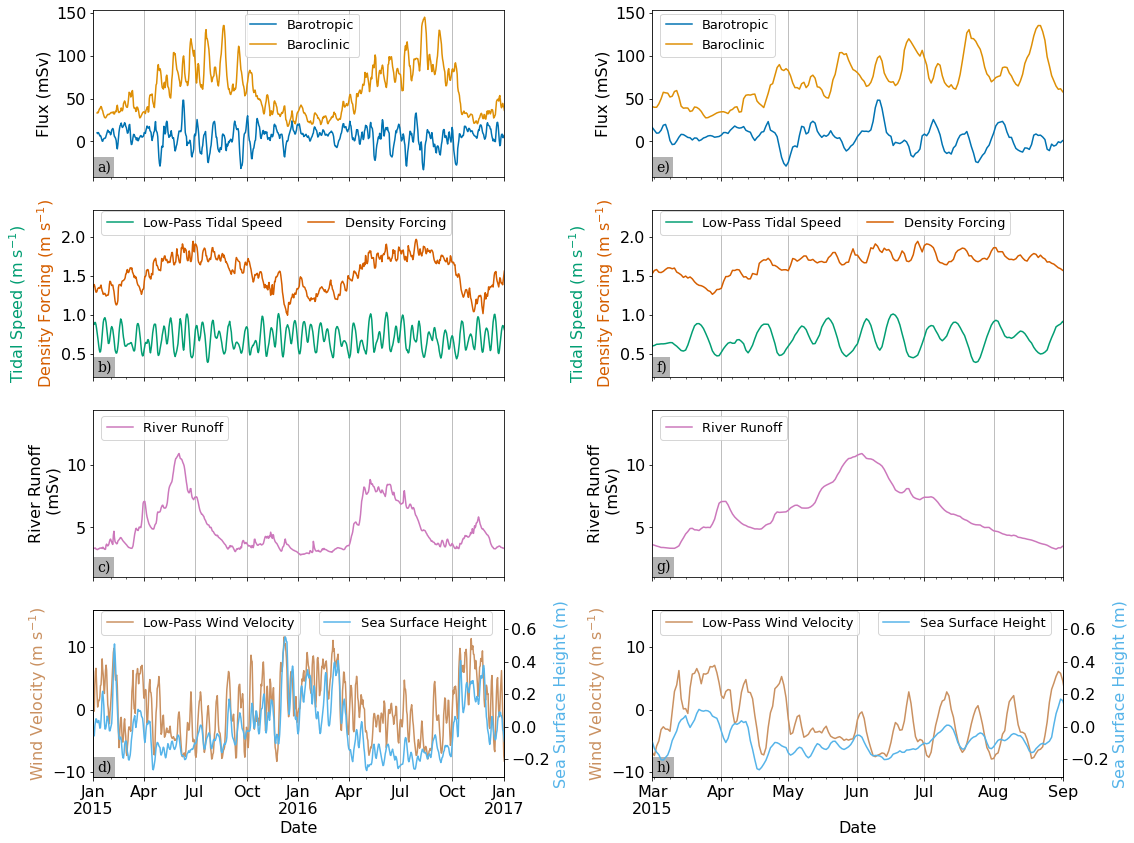

In [67]:
fig, axs = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(wspace=0.25)

mylabels = [['a)', 'e)'], ['b)', 'f)'], ['c)', 'g)'], ['d)', 'h)']]

for iax in range(2):
    (barotropic.transport/1000).plot(ax=axs[0, iax], color=myp[0], label="Barotropic")
    (baroclinic.transport/1000).plot(ax=axs[0, iax], color=myp[1], label="Baroclinic")
    np.sqrt(low_pass_tide.vozocrtx).plot(ax=axs[1, iax], color=myp[2], label="Low-Pass Tidal Speed")
    densityforcing.plot(ax=axs[1, iax], color=myp[3], label="Density Forcing")
    (SoGrunoff.rorunoff/1000).plot(ax=axs[2, iax], color=myp[4], label="River Runoff")
    low_pass_wind.wind.plot(ax=axs[3, iax], color=myp[5], label="Low-Pass Wind Velocity")
    axb = axs[3, iax].twinx()
    axb.set_ylabel('Sea Surface Height (m)',color=myp[9])
    ssh.sossheig.plot(ax=axb, color=myp[9], label="Sea Surface Height")
    axb.legend(loc=[0.55, 0.85], fontsize=13)   
    axb.set_ylim(None, 0.72)
    axb.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])

for ax in axs[:, 0]:
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 1, 1))
    
for ax in axs[:, 1]:
    ax.set_xlim(datetime.datetime(2015, 3, 1), datetime.datetime(2015, 9, 1))

for ax in axs[1, :]:
    ax.set_ylim(None, 2.35)
for ax in axs[3, :]:
    ax.set_ylim(None, 16)
    
#axs[1, 0].text(datetime.datetime(2014, 9, 1), -1.0, 'Tidal Speed Squared (m$^2$ s$^{-2}$)', 
#               rotation=90, color=myp[2])
#axs[1, 1].text(datetime.datetime(2015, 1, 29), -1.0, 'Tidal Speed Squared (m$^2$ s$^{-2}$)', 
#               rotation=90, color=myp[2])
axs[1, 0].text(datetime.datetime(2014, 8, 1), 0.2, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])
axs[1, 1].text(datetime.datetime(2015, 1, 22), 0.2, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])

for i in range(2):
    axs[1, i].set_ylim(bottom=0.2)
    axs[3, i].set_xlabel('Date')
    
    axs[0, i].set_ylabel('Flux (mSv)')
    axs[1, i].set_ylabel('Density Forcing (m s$^{-1}$)', color=myp[3])
    axs[2, i].set_ylabel("River Runoff\n (mSv)")
    axs[2, i].set_ylim(bottom=1)
    axs[3, i].set_ylabel('Wind Velocity (m s$^{-1}$)', color=myp[5])
    
    for j in range(3):
        axs[j, i].set_xticklabels([])
        axs[j, i].set_xlabel('')
        axs[j, i].legend(loc='best', fontsize=14)
    for j in range(4):
        axs[j, i].grid(axis='x')
        axs[j, i].text(0.01, 0.02, mylabels[j][i], transform=axs[j, i].transAxes,
            fontsize=14, verticalalignment='bottom', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
axs[0, 0].legend(loc=[0.37, 0.72], fontsize=13)        
axs[0, 1].legend(loc=[0.02, 0.72], fontsize=13)
axs[1, 0].legend(loc=[0.02, 0.85], fontsize=13, ncol=2)        
axs[1, 1].legend(loc=[0.02, 0.85], fontsize=13, ncol=2)
axs[2, 0].legend(loc=[0.02, 0.82], fontsize=13)        
axs[2, 1].legend(loc=[0.02, 0.82], fontsize=13)
axs[3, 0].legend(loc=[0.02, 0.85], fontsize=13)        
axs[3, 1].legend(loc=[0.02, 0.85], fontsize=13)

fig.tight_layout()
plt.savefig('Ancillary_v2.pdf')
plt.savefig('Ancillary_v2.png')

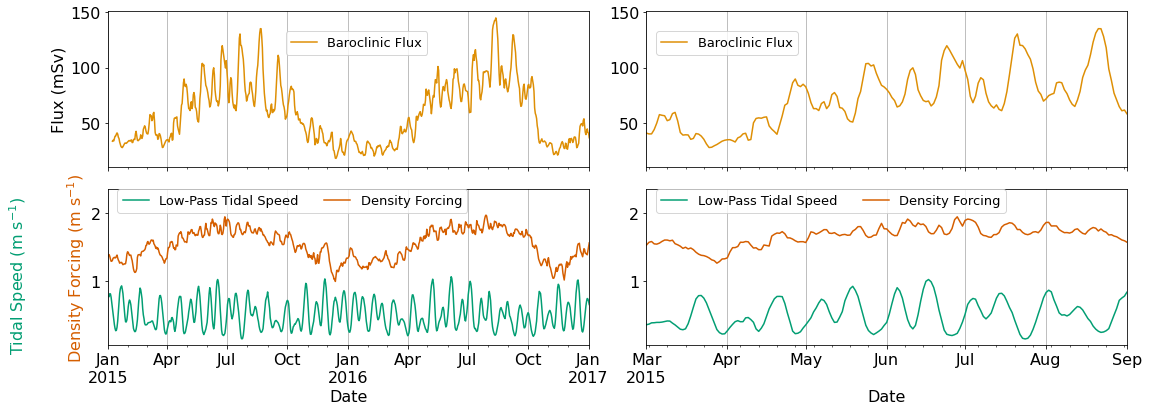

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.25)

for iax in range(2):
    (baroclinic.transport/1000).plot(ax=axs[0, iax], color=myp[1], label="Baroclinic Flux")
    low_pass_tide.vozocrtx.plot(ax=axs[1, iax], color=myp[2], label="Low-Pass Tidal Speed")
    densityforcing.plot(ax=axs[1, iax], color=myp[3], label="Density Forcing")

for ax in axs[:, 0]:
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 1, 1))
    
for ax in axs[:, 1]:
    ax.set_xlim(datetime.datetime(2015, 3, 1), datetime.datetime(2015, 9, 1))

for ax in axs[1, :]:
    ax.set_ylim(None, 2.35)
    
axs[1, 0].text(datetime.datetime(2014, 8, 1), 0.0, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])
#axs[1, 1].text(datetime.datetime(2015, 1, 22), 0.0, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])

for i in range(2):
    axs[1, i].set_xlabel('Date')
    axs[0, i].set_xticklabels([])
    axs[0, i].set_xlabel('')
    axs[1, i].legend(loc='best', fontsize=14)
    

    
    
    for j in range(2):
        axs[j, i].grid(axis='x')

axs[0, 0].set_ylabel('Flux (mSv)')
axs[1, 0].set_ylabel('Density Forcing (m s$^{-1}$)', color=myp[3])
       
axs[0, 0].legend(loc=[0.37, 0.72], fontsize=13)        
axs[0, 1].legend(loc=[0.02, 0.72], fontsize=13)
axs[1, 0].legend(loc=[0.02, 0.85], fontsize=13, ncol=2)        
axs[1, 1].legend(loc=[0.02, 0.85], fontsize=13, ncol=2)

fig.tight_layout()
plt.savefig('Ancillary_CMOS2024.pdf')
plt.savefig('Ancillary_CMOS2024.png')

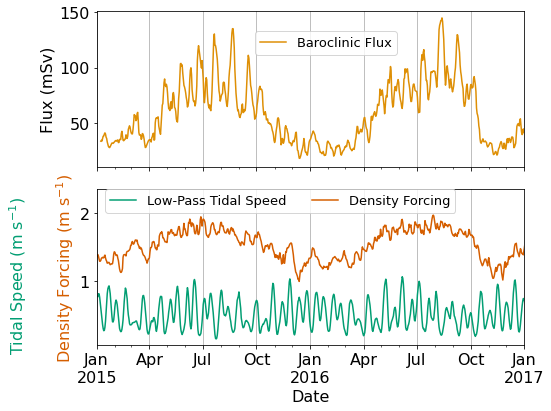

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
fig.subplots_adjust(wspace=0.25)

#(barotropic.transport/1000).plot(ax=axs[0], color=myp[0], label="Barotropic")
(baroclinic.transport/1000).plot(ax=axs[0], color=myp[1], label="Baroclinic Flux")
low_pass_tide.vozocrtx.plot(ax=axs[1], color=myp[2], label="Low-Pass Tidal Speed")
densityforcing.plot(ax=axs[1], color=myp[3], label="Density Forcing")

for ax in axs:
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 1, 1))

axs[1].set_ylim(None, 2.35)
    
axs[1].text(datetime.datetime(2014, 8, 1), 0.0, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])


axs[1].set_xlabel('Date')
    
axs[0].set_ylabel('Flux (mSv)')
axs[1].set_ylabel('Density Forcing (m s$^{-1}$)', color=myp[3])
    
    
axs[0].set_xticklabels([])
axs[0].set_xlabel('')
axs[0].legend(loc='best', fontsize=14)

for j in range(2):
    axs[j].grid(axis='x')

axs[0].legend(loc=[0.37, 0.72], fontsize=13)  
axs[1].legend(loc=[0.02, 0.85], fontsize=13, ncol=2)  


fig.tight_layout()
plt.savefig('Ancillary_CMOS2024.pdf')
plt.savefig('Ancillary_CMOS2024.png')

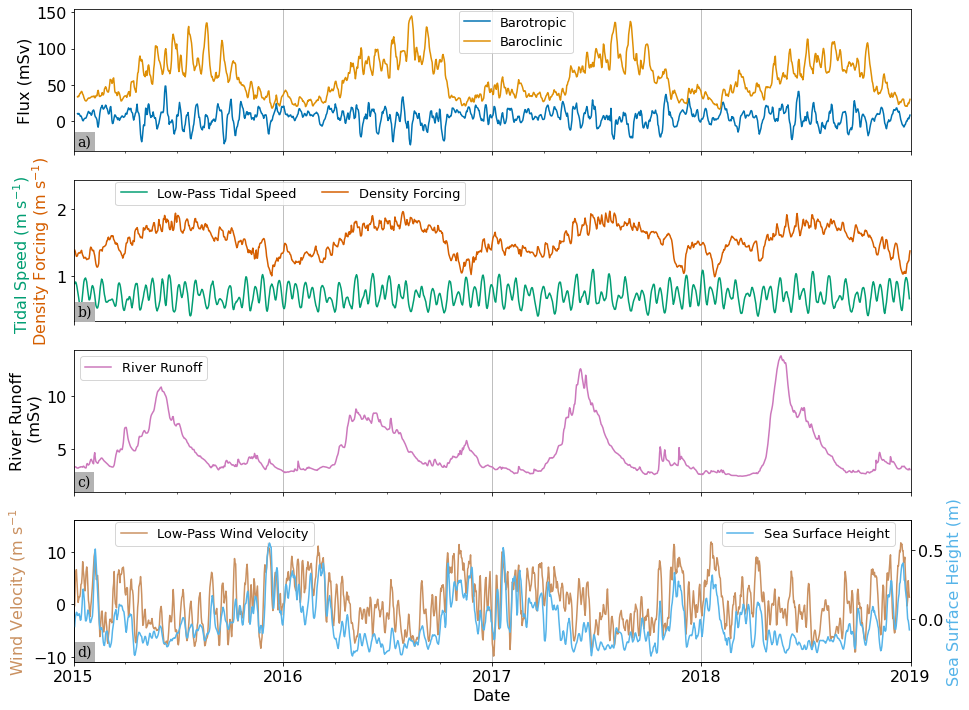

In [69]:
fig, axs = plt.subplots(4, 1, figsize=(15, 12))
fig.subplots_adjust(wspace=0.25)

mylabels = ['a)', 'b)', 'c)', 'd)']

(barotropic.transport/1000).plot(ax=axs[0], color=myp[0], label="Barotropic")
(baroclinic.transport/1000).plot(ax=axs[0], color=myp[1], label="Baroclinic")
#a1l1, = axs[1].plot(low_pass_tide.index, low_pass_tide.vozocrtx, color=myp[2], label="Low-Pass Tidal Speed")
np.sqrt(low_pass_tide.vozocrtx).plot(ax=axs[1], color=myp[2], label="Low-Pass Tidal Speed")
#a1l2, = axs[1].plot(densityforcing.index, densityforcing, color=myp[3], label="Density Forcing")
densityforcing.plot(ax=axs[1], color=myp[3], label="Density Forcing")
(SoGrunoff.rorunoff/1000).plot(ax=axs[2], color=myp[4], label="River Runoff")
low_pass_wind.wind.plot(ax=axs[3], color=myp[5], label="Low-Pass Wind Velocity")
axb = axs[3].twinx()
axb.set_ylabel('Sea Surface Height (m)',color=myp[9])
ssh.sossheig.plot(ax=axb, color=myp[9], label="Sea Surface Height")
axb.legend(loc=[0.775, 0.82], fontsize=13)   
axb.set_ylim(None, 0.72)
    

for ax in axs:
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2019, 1, 1))

axs[1].set_ylim(None, 2.45)    
axs[3].set_ylim(None, 16)
        
axs[1].text(datetime.datetime(2014, 9, 15), 0.2, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])


axs[3].set_xlabel('Date')

axs[0].set_ylabel('Flux (mSv)')
axs[1].set_ylabel('Density Forcing (m s$^{-1}$)', color=myp[3])
axs[2].set_ylabel("River Runoff\n (mSv)")
axs[2].set_ylim(bottom=1)
axs[3].set_ylabel('Wind Velocity (m s$^{-1}$', color=myp[5])
    
for j in range(3):
    axs[j].set_xticklabels([])
    axs[j].set_xlabel('')
    axs[j].legend(loc='best')
axs[0].legend(loc=(0.46, 0.69), fontsize=13)
axs[1].legend(loc=(0.05, 0.82), fontsize=13, ncol=2)
axs[2].legend(loc='best', fontsize=13)
axs[3].legend(loc=[0.05, 0.82], fontsize=13)      
for j in range(4):
    axs[j].grid(axis='x')
    axs[j].text(0.005, 0.02, mylabels[j], transform=axs[j].transAxes,
        fontsize=14, verticalalignment='bottom', fontfamily='serif',
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
        
plt.savefig('Ancillary_sup_v2.pdf')
plt.savefig('Ancillary_sup_v2.png')

In [11]:
plt.rcParams['font.size'] = 14

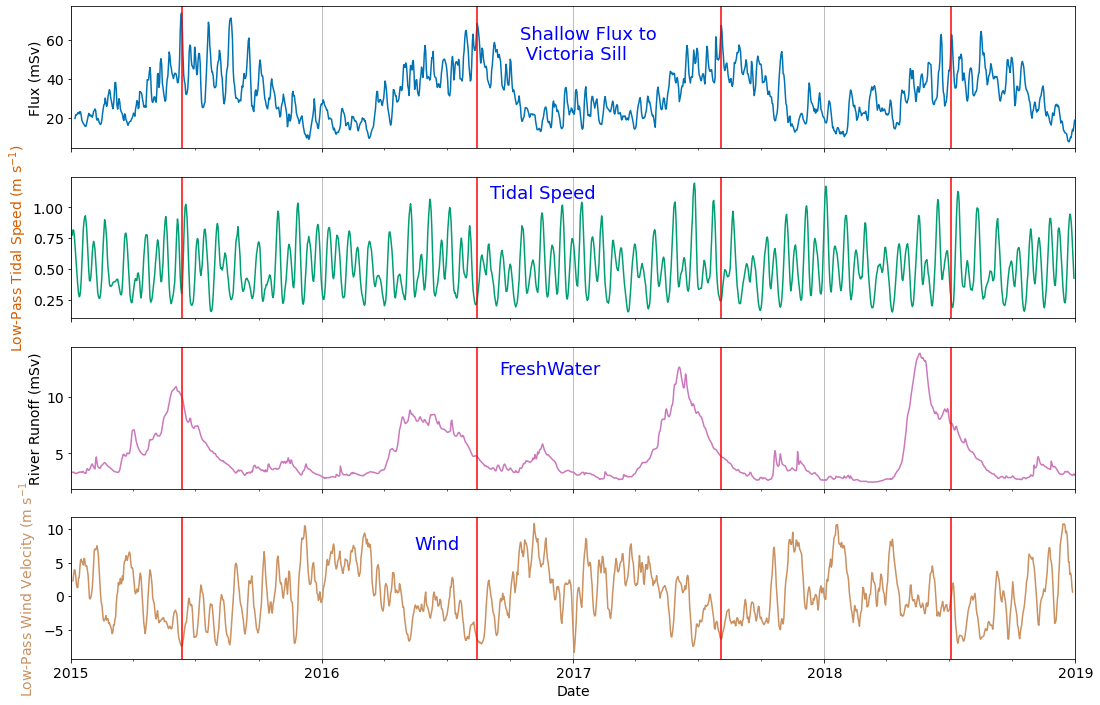

In [12]:
fig, axs = plt.subplots(4, 1, figsize=(18, 12))
fig.subplots_adjust(wspace=0.25)


(shallow_flux.transport/1000).plot(ax=axs[0], color=myp[0], label="Shallow Flux")    
low_pass_tide.vozocrtx.plot(ax=axs[1], color=myp[2], label="Low-Pass Tidal Speed")
(SoGrunoff.rorunoff/1000).plot(ax=axs[2], color=myp[4], label="River Runoff")
low_pass_wind.wind.plot(ax=axs[3], color=myp[5], label="Low-Pass Wind Velocity")
    

for ax in axs[:]:
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2019, 1, 1))
    

axs[3].set_xlabel('Date')
    
axs[0].set_ylabel('Flux (mSv)')
axs[1].set_ylabel('Low-Pass Tidal Speed (m s$^{-1}$)', color=myp[3])
axs[2].set_ylabel("River Runoff (mSv)")
axs[3].set_ylabel('Low-Pass Wind Velocity (m s$^{-1}$', color=myp[5])
    
for j in range(3):
        axs[j].set_xticklabels([])
        axs[j].set_xlabel('')
for j in range(4):
        axs[j].grid(axis='x')
        
axs[0].text(datetime.datetime(2016, 10, 15), 50, 'Shallow Flux to\n Victoria Sill', color='b', fontsize=18);
axs[1].text(datetime.datetime(2016, 9, 1), 1.07, 'Tidal Speed', color='b', fontsize=18);
axs[2].text(datetime.datetime(2016, 9, 15), 12, 'FreshWater', color='b', fontsize=18);
axs[3].text(datetime.datetime(2016, 5, 15), 7, 'Wind', color='b', fontsize=18);

p1 = datetime.datetime(2015, 6, 11)
for ax in axs:
    ax.axvline(x=p1, color='r')
    
p2 = datetime.datetime(2016, 8, 13)
for ax in axs:
    ax.axvline(x=p2, color='r')
    
p3 = datetime.datetime(2017, 8, 3)
for ax in axs:
    ax.axvline(x=p3, color='r')
    
p4 = datetime.datetime(2018, 7, 4)
for ax in axs:
    ax.axvline(x=p4, color='r')

#fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/Leblond_forcing.png')

In [13]:
## Just Look at Barotropic Flux

In [14]:
barotropic[0:2]

,transport
2015-01-01 00:00:00+00:00,NaN
2015-01-02 00:00:00+00:00,NaN


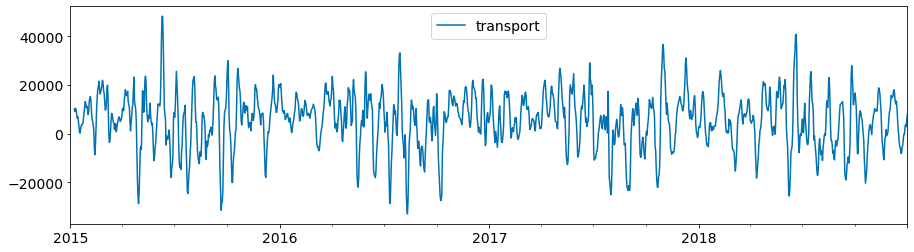

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
barotropic.plot(ax=ax);

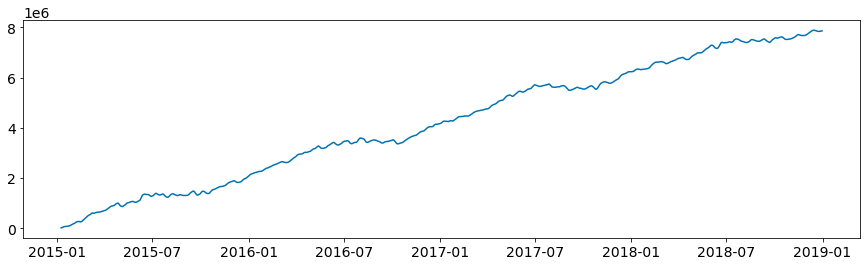

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(barotropic.index, np.cumsum(barotropic.transport));

In [17]:
## So consistently out

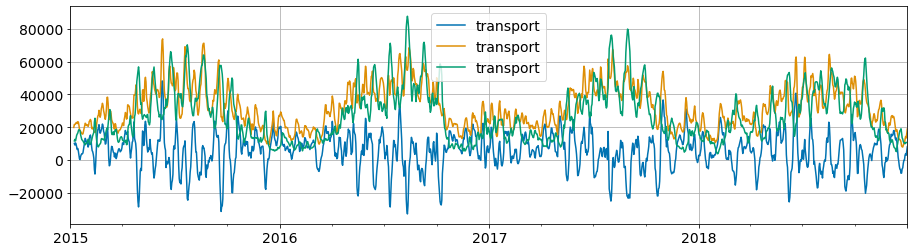

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
barotropic.plot(ax=ax);
shallow_flux.plot(ax=ax);
deep_flux.plot(ax=ax);
#ax.set_xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31))
ax.grid();

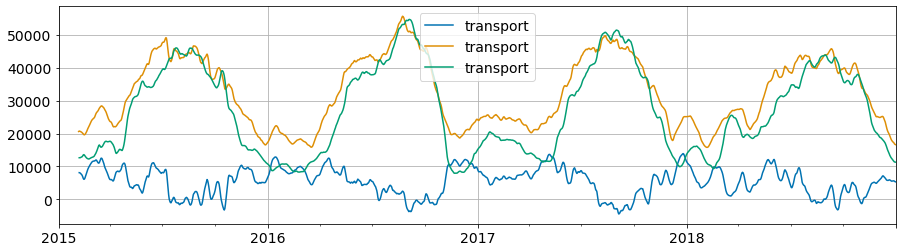

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
barotropic.rolling(window=30).mean().plot(ax=ax);
shallow_flux.rolling(window=30).mean().plot(ax=ax);
deep_flux.rolling(window=30).mean().plot(ax=ax);
#ax.set_xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31))
ax.grid();

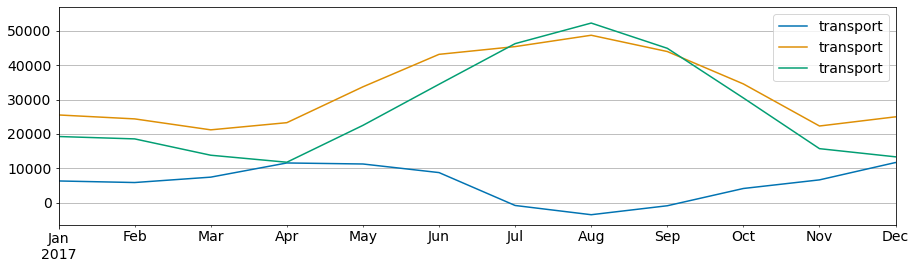

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
barotropic.resample('M').mean().plot(ax=ax);
shallow_flux.resample('M').mean().plot(ax=ax);
deep_flux.resample('M').mean().plot(ax=ax);
ax.set_xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31))
ax.grid();

In [21]:
print(23.8+8)
shallow_flux.mean()

31.8


transport    32148.180265
dtype: float64

In [22]:
print(23.7+2.2)
deep_flux.mean()

25.9


transport    26750.82219
dtype: float64

Yearly Values

In [25]:
SoGrunoff.groupby(SoGrunoff.index.year).mean()

,rorunoff
datetime,
2015,4918.779428
2016,4854.659295
2017,4719.688140
2018,4726.770248


In [27]:
densityforcing.groupby(densityforcing.index.year).mean()

2015    1.538397
2016    1.526091
2017    1.559422
2018    1.535584
dtype: float64

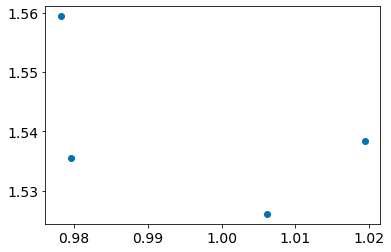

In [31]:
plt.plot(SoGrunoff.groupby(SoGrunoff.index.year).mean()/4825, densityforcing.groupby(densityforcing.index.year).mean(), 'o')

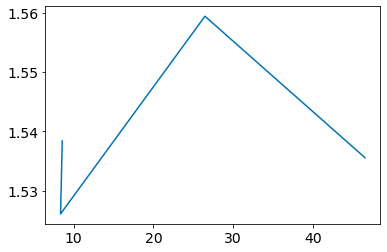

In [52]:
plt.plot(-ssh.groupby(ssh.index.year).sossheig.mean().values*
         (SoGrunoff.groupby(SoGrunoff.index.year).mean().values.transpose()[0]-4000), 
            densityforcing.groupby(densityforcing.index.year).mean().values)

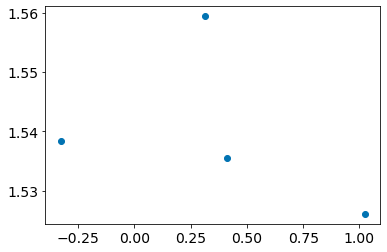

In [55]:
plt.plot(low_pass_wind.wind.groupby(low_pass_wind.index.year).mean(),
          densityforcing.groupby(densityforcing.index.year).mean(), 'o')

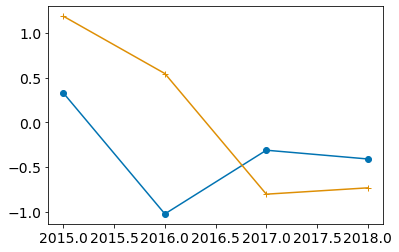

In [81]:
plt.plot(-low_pass_wind.wind.groupby(low_pass_wind.index.year).mean(), 'o-')
plt.plot((SoGrunoff.groupby(SoGrunoff.index.year).mean()-4800)/100, '+-')
#plt.plot(20*(densityforcing.groupby(densityforcing.index.year).mean()-1.52), 's-')
#plt.plot(np.arange(2015, 2019), -(SoGrunoff.groupby(SoGrunoff.index.year).mean().values.transpose()[0]-4800)/100 
#         -low_pass_wind.wind.groupby(low_pass_wind.index.year).mean().values, '*--')